# Geneformer Zero-Shot Ovarian Cancer Baseline

This notebook prepares a Geneformer baseline on the ovarian cancer dataset and saves:
- the tokenized dataset to disk for reuse,
- model evaluation results for comparison.


In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

# Prefer absolute paths on the cluster
PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'ovarian_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

# Ensure local package imports work
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Set environment variables for local cache directories
os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config (ovarian)
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/ovarian_cancer_with_celltypes_v1.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / dataset_name).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

# Placeholders; will be finalized after inspection cells
gene_col = 'gene_symbols'
batch_col = 'sample'     # to be validated
label_col = 'cell_type'  # to be validated
layer_key = 'X'

RUN_TAG = 'full'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V2-104M_CLcancer').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/ovarian_cancer_with_celltypes_v1.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 8
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()

geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-12 02:03:58 | Using device cuda
INFO     | 2025-08-12 02:04:28 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer


In [5]:
# Inspect dataset to determine columns and structure
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

if 'gene_symbols' in ad.var.columns:
    gene_col = 'gene_symbols'
else:
    gene_col = None
print('gene_col ->', gene_col if gene_col else 'var.index')

print('n unique labels:', ad.obs[label_col].nunique() if label_col in ad.obs else 'NA')
print('label example counts:\n', ad.obs[label_col].astype(str).value_counts().head(20) if label_col in ad.obs else 'NA')


adata shape: (65144, 24516)
obs columns: ['sample', 'cell_type', 'cell_subtype', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'disease', 'histology', 'source', 'stage', 'sample_cancer_type', 'sample_technology', 'sample_n_cells', 'sample_sample_histology', 'sample_sample_source', 'sample_sample_stage', 'sample_grade', 'sample_age_at_diagnosis', 'sample_race', 'sample_bmi', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']
var columns: ['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']
label_col -> cell_type
batch_col -> sample
gene_col -> var.index
n unique labels: 8
label example counts:
 cell_type
Malignant      28699
Fibroblast     19564
Macrophage      5837
Endothelial     4795
T_ce

In [6]:
# Load and preprocess data to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(in_dataset_path))

inp.preprocess_data(
    gene_col=gene_col if gene_col else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_path = preprocessed_path / f'{dataset_name}.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-12 02:06:35 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/ovarian_cancer_with_celltypes_v1.h5ad
WARNING  | 2025-08-12 02:08:00 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-12 02:08:07 | Matched 99.01% genes (20803/21011) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1/ovarian_cancer_with_celltypes_v1.h5ad exists: True


In [7]:
# Verify/update columns post-preprocess
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1/ovarian_cancer_with_celltypes_v1.h5ad


In [8]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

dataset_dir = preprocessed_path / f'{dataset_name}.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)


WARNING  | 2025-08-12 02:09:27 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1/ovarian_cancer_with_celltypes_v1.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1/ovarian_cancer_with_celltypes_v1.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 65144
Sample input_ids length: 4125
Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1/ovarian_cancer_with_celltypes_v1.dataset exists: True
save_to_disk skipped: Tried to overwrite /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/ovarian_cancer_with_celltypes_v1/ovarian_cancer_with_celltypes_v1.dataset but a dataset can't overwrite itself.
Saved row_order.csv
Saved manifest.json
Archived tokenized dataset to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovaria

In [9]:
# Load back, extract embeddings, and quick eval

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Geneformer (extracting embeddings): 100%|██████████| 8143/8143 [3:36:41<00:00,  1.60s/it]  
DEBUG    | 2025-08-12 05:54:40 | Extracting output from 500 cells
WARNING  | 2025-08-12 05:54:52 | adata_ has 65144 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-12 05:54:52 | Computing metrics for cell_type
DEBUG    | 2025-08-12 05:54:59 | NMI_cluster/label: 0.4756
ARI_cluster/label: 0.3321
ASW_label: 0.4916
graph_conn: 0.9249
ASW_batch: 0.4808
ASW_label/batch: 0.8211
PCR_batch: 0.0208
avg_bio: 0.4331
DEBUG    | 2025-08-12 05:54:59 | NMI_cluster/label for cell_type: 0.47564591029633413
DEBUG    | 2025-08-12 05:54:59 | ARI_cluster/label for cell_type: 0.3321293181145999
DEBUG    | 2025-08-12 05:54:59 | ASW_label for cell_type: 0.49163082242012024
DEBUG    | 2025-08-12 05:54:59 | graph_conn for cell_type: 0.9248619240194978
DEBUG    | 2025-08-12 05:54:59 | ASW_batch for cell_type: 0.48080095648765564
DEBUG    | 2025-08-12 05:54:59 | ASW_label/batch for cell_type: 0.8211192488670349
DEB

,metric,label,value
0,NMI_cluster/label,cell_type,0.475646
1,ARI_cluster/label,cell_type,0.332129
2,ASW_label,cell_type,0.491631
3,graph_conn,cell_type,0.924862
4,ASW_batch,cell_type,0.480801
5,ASW_label/batch,cell_type,0.821119
6,PCR_batch,cell_type,0.020797
7,avg_bio,cell_type,0.433135


In [10]:
# Ensemble evaluation and saving
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_ovarian_results_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_ovarian_metrics_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-12 05:55:00 | Initialized GeneformerEnsembleMetrics with 65144 cells and 8 classes
INFO     | 2025-08-12 05:55:00 | Classes: ['B_cell', 'Endothelial', 'Fibroblast', 'Macrophage', 'Malignant', 'Mast', 'Myocyte', 'T_cell']
INFO     | 2025-08-12 05:55:00 | Embedding shape: (65144, 768)
INFO     | 2025-08-12 05:55:00 | Input rankings length: 65144
INFO     | 2025-08-12 05:55:00 | Output rankings length: 65144
INFO     | 2025-08-12 05:55:00 | Evaluated embedding_only (α=0.0): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=0.0: F1=0.656, AUC=0.838, Acc=0.635


INFO     | 2025-08-12 05:55:00 | Evaluated embedding_only (α=0.1): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=0.1: F1=0.656, AUC=0.838, Acc=0.635


INFO     | 2025-08-12 05:55:01 | Evaluated embedding_only (α=0.3): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=0.3: F1=0.656, AUC=0.838, Acc=0.635


INFO     | 2025-08-12 05:55:01 | Evaluated embedding_only (α=0.5): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=0.5: F1=0.656, AUC=0.838, Acc=0.635


INFO     | 2025-08-12 05:55:01 | Evaluated embedding_only (α=0.7): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=0.7: F1=0.656, AUC=0.838, Acc=0.635


INFO     | 2025-08-12 05:55:02 | Evaluated embedding_only (α=0.9): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=0.9: F1=0.656, AUC=0.838, Acc=0.635


INFO     | 2025-08-12 05:55:02 | Evaluated embedding_only (α=1.0): Accuracy=0.635, F1=0.656, AUC-ROC=0.838


alpha=1.0: F1=0.656, AUC=0.838, Acc=0.635
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs/geneformer_ovarian_results_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs/geneformer_ovarian_metrics_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs/geneformer_ovarian_confusion_matrix_full.png


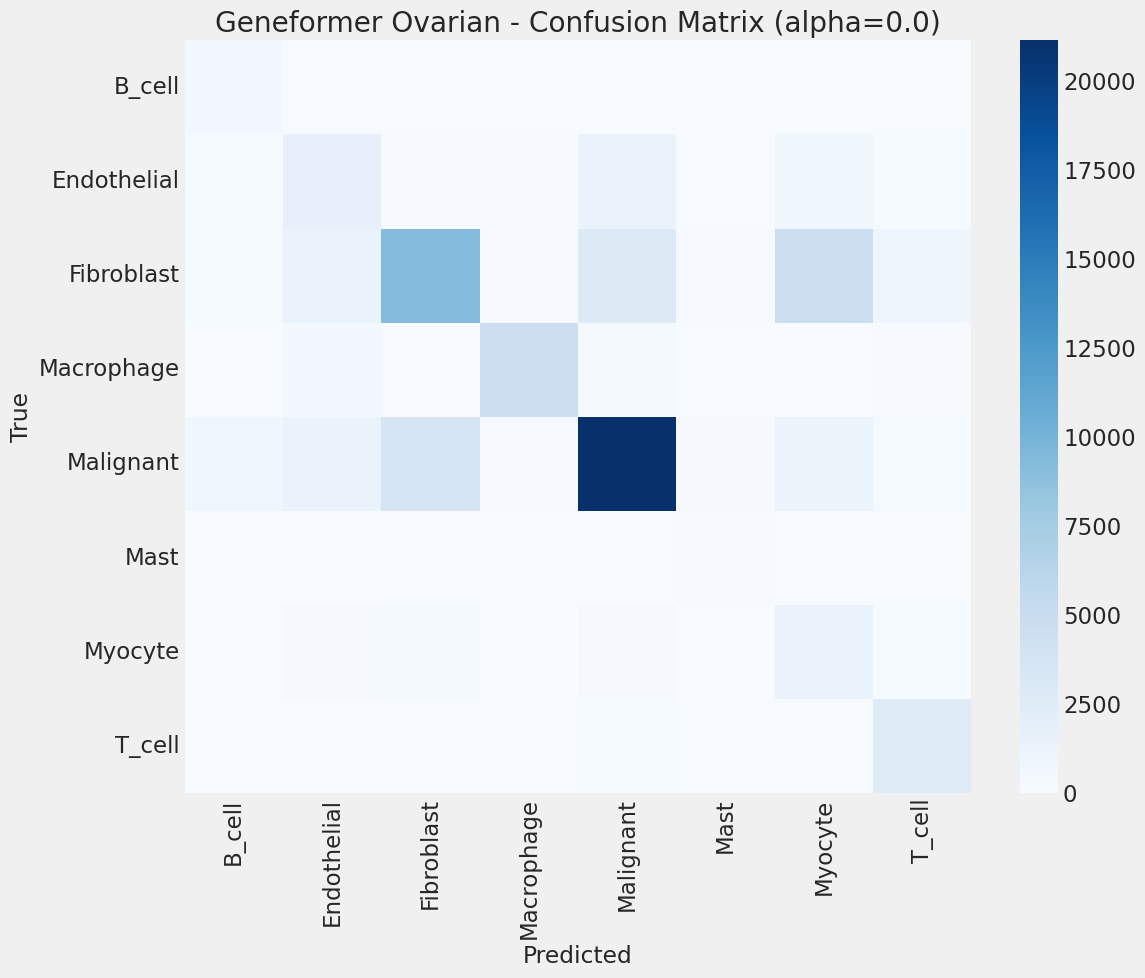

In [11]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Ovarian - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_ovarian_confusion_matrix_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs/geneformer_ovarian_umap_coords_full.csv


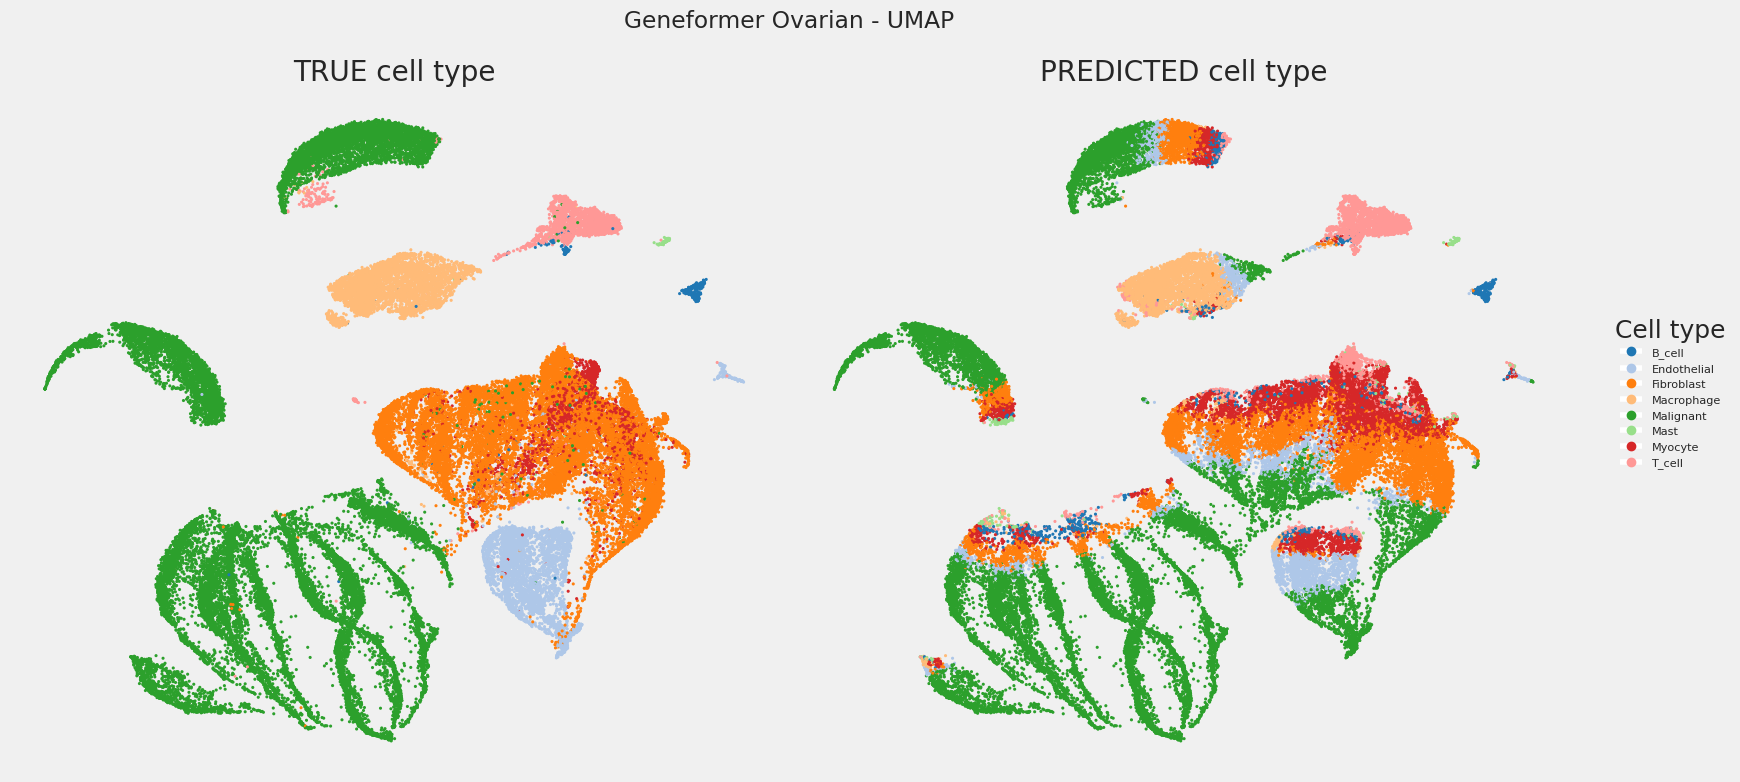

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs/geneformer_ovarian_umap_true_pred_with_legend_full.png


In [12]:
# UMAP of true vs predicted labels with side legend
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
class_names = list(em.class_names)
preds_arr = np.asarray(preds)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

coords_path = MODEL_OUT / f'geneformer_ovarian_umap_coords_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(handles=handles, labels=unique_levels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Ovarian - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_ovarian_umap_true_pred_with_legend_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [13]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

results_path = MODEL_OUT / f'geneformer_ovarian_results_{RUN_TAG}.pt'

res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception:
    pass
if res is None:
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V2-104M_CLcancer
Dataset: ovarian_cancer_with_celltypes_v1
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.6350
  precision: 0.7048
  recall: 0.6350
  f1_score: 0.6560
  auc_roc: 0.8382
  avg_precision: 0.6093

Classification report:
              precision    recall  f1-score   support

      B_cell     0.2425    0.7832    0.3703       535
 Endothelial     0.3387    0.3779    0.3572      4795
  Fibroblast     0.6857    0.4702    0.5579     19564
  Macrophage     0.9200    0.8001    0.8559      5837
   Malignant     0.8050    0.7362    0.7690     28699
        Mast     0.2058    0.8897    0.3343       136
     Myocyte     0.1666    0.5505    0.2558      2523
      T_cell     0.5964    0.8599    0.7043      3055

    accuracy                         0.6350     65144
   macro avg     0.4951    0.6835    0.5256     65144
weighted avg     0.7048    0.6350    0.6560     65144



In [14]:
# Debug: Check what the ensemble evaluation actually used
print("=== ENSEMBLE EVALUATION DEBUG - OVARIAN BASELINE ===")
print(f"Ensemble embeddings shape: {em.embeddings.shape}")
print(f"Ensemble labels shape: {em.labels_encoded.shape}")
print(f"Ensemble predictions shape: {preds.shape}")
print(f"Ensemble class names: {em.class_names}")

# Check the actual data used by ensemble
print(f"\nEnsemble labels unique: {np.unique(em.labels_encoded)}")
print(f"Ensemble predictions unique: {np.unique(preds)}")

# Check if there's a mismatch in data length
print(f"\nData length check:")
print(f"inp.adata shape: {inp.adata.shape}")
print(f"em.embeddings length: {len(em.embeddings)}")
print(f"em.labels_encoded length: {len(em.labels_encoded)}")
print(f"preds length: {len(preds)}")

# Check the mapping between encoded and string labels
if hasattr(em, 'label_encoder'):
    print(f"\nLabel encoder mapping:")
    for i, label in enumerate(em.class_names):
        print(f"  {i} -> {label}")

# Use the ensemble's actual data for consistent results
print("\n=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===")

# Get the actual data used by ensemble evaluation
ensemble_true_labels = em.labels_encoded  # These are the encoded labels (0,1,2,...)
ensemble_predictions = preds              # These are the predictions (0,1,2,...)

print(f"Ensemble true labels: {np.unique(ensemble_true_labels)}")
print(f"Ensemble predictions: {np.unique(ensemble_predictions)}")

# Convert back to string labels for readability
ensemble_true_strings = np.array([em.class_names[label] for label in ensemble_true_labels])
ensemble_pred_strings = np.array([em.class_names[label] for label in ensemble_predictions])

print(f"Ensemble true strings: {np.unique(ensemble_true_strings)}")
print(f"Ensemble pred strings: {np.unique(ensemble_pred_strings)}")

# Now calculate metrics using ensemble data
print("\n=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===")
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=em.class_names,
                         digits=4))

# Calculate metrics
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='macro', zero_division=0)

print(f"\nMetrics using ensemble data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")

# These should match the ensemble evaluation results!

=== ENSEMBLE EVALUATION DEBUG - OVARIAN BASELINE ===
Ensemble embeddings shape: (65144, 768)
Ensemble labels shape: (65144,)
Ensemble predictions shape: (65144,)
Ensemble class names: ['B_cell' 'Endothelial' 'Fibroblast' 'Macrophage' 'Malignant' 'Mast'
 'Myocyte' 'T_cell']

Ensemble labels unique: [0 1 2 3 4 5 6 7]
Ensemble predictions unique: [0 1 2 3 4 5 6 7]

Data length check:
inp.adata shape: (65144, 20803)
em.embeddings length: 65144
em.labels_encoded length: 65144
preds length: 65144

Label encoder mapping:
  0 -> B_cell
  1 -> Endothelial
  2 -> Fibroblast
  3 -> Macrophage
  4 -> Malignant
  5 -> Mast
  6 -> Myocyte
  7 -> T_cell

=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===
Ensemble true labels: [0 1 2 3 4 5 6 7]
Ensemble predictions: [0 1 2 3 4 5 6 7]
Ensemble true strings: ['B_cell' 'Endothelial' 'Fibroblast' 'Macrophage' 'Malignant' 'Mast'
 'Myocyte' 'T_cell']
Ensemble pred strings: ['B_cell' 'Endothelial' 'Fibroblast' 'Macrophage' 'Malignant' 'Mast'
 'Myocyte' 'T_ce

COMPLETE MULTI-CLASS CELL TYPE CLASSIFICATION REPORT - OVARIAN BASELINE
              precision    recall  f1-score   support

      B_cell     0.2425    0.7832    0.3703       535
 Endothelial     0.3387    0.3779    0.3572      4795
  Fibroblast     0.6857    0.4702    0.5579     19564
  Macrophage     0.9200    0.8001    0.8559      5837
   Malignant     0.8050    0.7362    0.7690     28699
        Mast     0.2058    0.8897    0.3343       136
     Myocyte     0.1666    0.5505    0.2558      2523
      T_cell     0.5964    0.8599    0.7043      3055

    accuracy                         0.6350     65144
   macro avg     0.4951    0.6835    0.5256     65144
weighted avg     0.7048    0.6350    0.6560     65144


DETAILED METRICS
Per-class metrics:
B_cell - Precision: 0.2425, Recall: 0.7832, F1: 0.3703, Support: 535
Endothelial - Precision: 0.3387, Recall: 0.3779, F1: 0.3572, Support: 4795
Fibroblast - Precision: 0.6857, Recall: 0.4702, F1: 0.5579, Support: 19564
Macrophage - Precisio

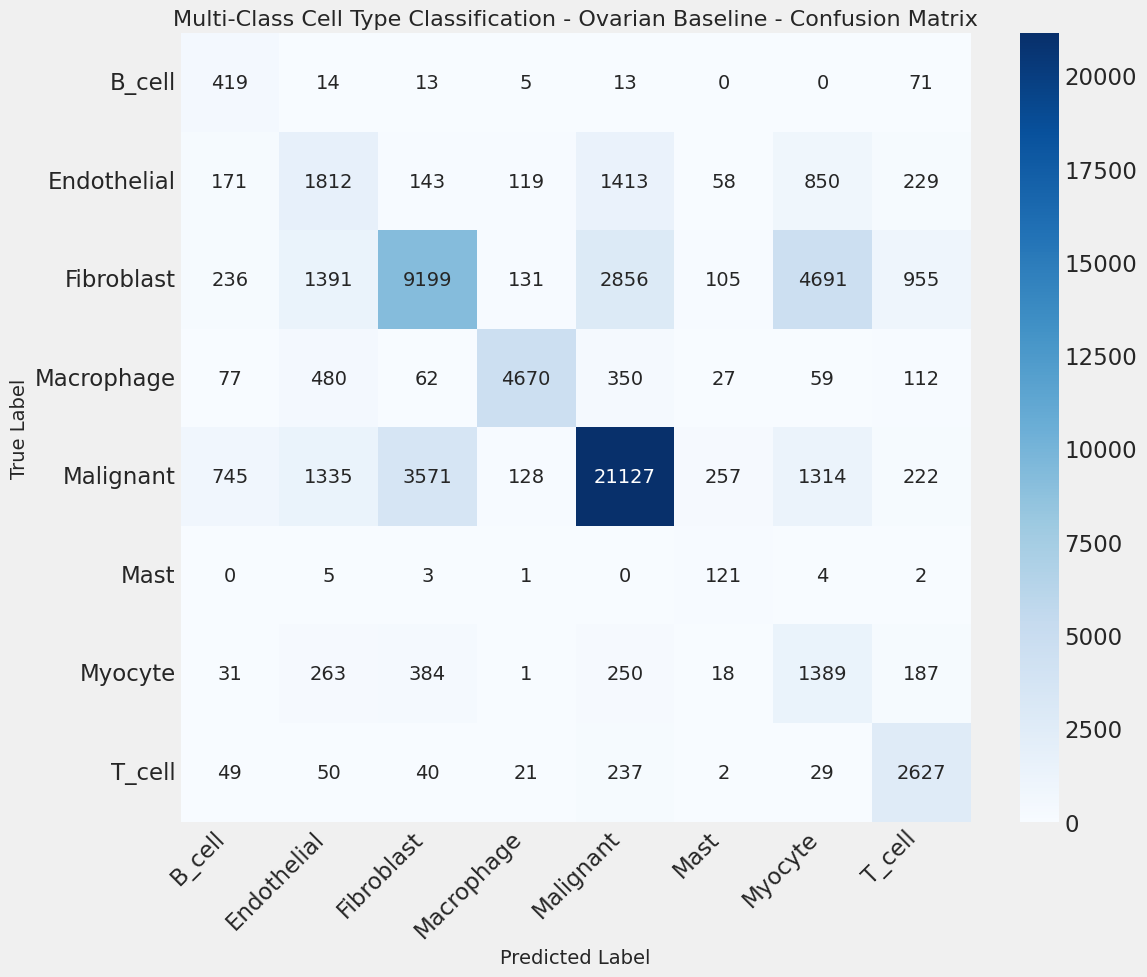

Confusion matrix plot saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/ovarian_baseline/model_outputs/ovarian_baseline_confusion_matrix.png

SUMMARY
✅ Accuracy: 0.6350 (matches ensemble evaluation)
✅ Macro F1-Score: 0.5256
✅ Weighted F1-Score: 0.6560

Dataset: Ovarian Cancer Baseline
Total cells: 65144
Number of cell types: 8
Cell type distribution:
  B_cell: 535 (0.8%)
  Endothelial: 4795 (7.4%)
  Fibroblast: 19564 (30.0%)
  Macrophage: 5837 (9.0%)
  Malignant: 28699 (44.1%)
  Mast: 136 (0.2%)
  Myocyte: 2523 (3.9%)
  T_cell: 3055 (4.7%)


<Figure size 640x480 with 0 Axes>

In [15]:
# Complete Classification Report using Ensemble Data for Ovarian Baseline
print("="*60)
print("COMPLETE MULTI-CLASS CELL TYPE CLASSIFICATION REPORT - OVARIAN BASELINE")
print("="*60)

# Print full classification report
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=em.class_names,
                         digits=4))

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)

# Calculate all metrics using ensemble data
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)

# Per-class metrics
print("Per-class metrics:")
class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
    ensemble_true_labels, ensemble_predictions, average=None, zero_division=0
)

for i, class_name in enumerate(em.class_names):
    print(f"{class_name} - Precision: {class_precision[i]:.4f}, Recall: {class_recall[i]:.4f}, F1: {class_f1[i]:.4f}, Support: {class_support[i]}")

# Overall metrics
macro_precision = np.mean(class_precision)
macro_recall = np.mean(class_recall)
macro_f1 = np.mean(class_f1)
weighted_precision = np.average(class_precision, weights=class_support)
weighted_recall = np.average(class_recall, weights=class_support)
weighted_f1 = np.average(class_f1, weights=class_support)

print(f"\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predictions)
print("Raw confusion matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names)
plt.title('Multi-Class Cell Type Classification - Ovarian Baseline - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save the plot
cm_plot_path = MODEL_OUT / 'ovarian_baseline_confusion_matrix.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix plot saved to: {cm_plot_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Accuracy: {accuracy:.4f} (matches ensemble evaluation)")
print(f"✅ Macro F1-Score: {macro_f1:.4f}")
print(f"✅ Weighted F1-Score: {weighted_f1:.4f}")

# Additional ovarian baseline specific info
print(f"\nDataset: Ovarian Cancer Baseline")
print(f"Total cells: {len(ensemble_true_labels)}")
print(f"Number of cell types: {len(em.class_names)}")
print(f"Cell type distribution:")
for i, class_name in enumerate(em.class_names):
    count = class_support[i]
    percentage = count / len(ensemble_true_labels) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")